In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.signal import fftconvolve, correlate
from scipy.interpolate import interp1d
import pandas as pd
import os

In [18]:
# ====================== USER INPUT ======================
signal_dir =r"Z:\Jacob\Material CrPS4\Undoped\06252025 Final VTTRPL fast PQ and PMTVTPL"
signal_file = "Signal_file.txt"
file_irf = r"Z:\Jacob\Material CrPS4\Undoped\06252025 Final VTTRPL fast PQ and PMTVTPL\IRF_file.txt"

analyze_all_columns = False # Set to True to analyze all signal columns; False to analyze a specific column
signal_column = 1  # Column number to analyze or plot (starting from 1 for the second column)

decay_time_initial = 6.512  # Initial guess for decay time
amplitude_scalar_initial = .03  # Initial guess for IRF scaling
model_amplitude_scalar_initial = 1 # Initial guess for model scaling
SkipRows_irf = 1
SkipRows_signal = 1
Invert_data = False # multiply data by -1 for inverted data
time_scalar = 1 #multiply x axis of signal
baseline_points = 500  # <-- number of initial points to average for baseline subtraction


bounds1 = [(1, 6.5121), (21.5, 23), (0.85, 1.1), (21,24), (.01,.05)]  
#(decay time, irf time shift, amplitude scalar,model time offset, model amplitude scalar)

n = 40 #number of points to average to find the time at which the signal is at a maximum and to normalize the signal

chi_end = 80 #will be adjusted later to be this value x lifetime to cover only the main range
chi_start = 15

model_type = 'FFT' # linear or FFT
# ==============================
# Guide for bounds
# ==============================
#decay time is tau
#irf time shift is approximately the time in the data where the rise time matches the irf
#amplitude scalar is roughly 1 because everything is normalized but maybe there is some wiggle room
#model time offset is approximately the time in the data where the PL is maximum
#model amplitude scalar is roughly 1 because everything is normalized but maybe there is some wiggle room


In [20]:
# ==============================
# Load Data
# ==============================
# -----------
# Load signal
# -----------
file_signal = os.path.join(signal_dir, signal_file)

# Strategy: use genfromtxt to allow blanks -> NaN, then drop any columns that are entirely NaN.
data_raw = np.genfromtxt(
    file_signal,
    delimiter='\t',
    skip_header=SkipRows_signal,
    dtype=float,
    filling_values=np.nan  # blanks become NaN instead of raising
)

# Ensure 2D even if there's only one row/column
if data_raw.ndim == 1:
    data_raw = data_raw[None, :]

# Drop columns that are entirely NaN (e.g., the trailing blank column)
valid_cols_mask = ~np.all(np.isnan(data_raw), axis=0)
data = data_raw[:, valid_cols_mask]

# Optional: if any remaining NaNs exist inside the kept columns (rare for your case),
# you can either (a) interpolate them or (b) zero them. Here we assert none remain:
if np.isnan(data).any():
    # If you prefer strict behavior, raise:
    # raise ValueError("Signal file contains internal NaNs after dropping all-NaN columns.")
    # Or gently fill with zeros (or do 1D interpolation per column):
    data = np.nan_to_num(data, copy=False)
    
time_irf, IRF_t = np.loadtxt(file_irf, unpack=True, skiprows=SkipRows_irf)
IRF_t -= np.mean(IRF_t[0:50])  # Set minimum to zero
IRF_t /= np.max(IRF_t)  # Normalize IRF
IRF_t = np.where(IRF_t < 0.01, 0, IRF_t) #get rid of noise in the baseline

# Shift IRF max to zero time
time_irf_zeroed = time_irf - time_irf[np.argmax(IRF_t)]

# Use the cleaned data loaded above
time_signal = time_scalar*data[:, 0]  # First column is always time
num_columns = data.shape[1] - 1  # Number of signal columns

# Subtract baseline from each signal column (not from time column)
for j in range(1, data.shape[1]):
    baseline = np.mean(data[:baseline_points, j])
    data[:, j] = data[:, j] - baseline


# ==============================
# Define Reconvolution Model
# ==============================
if model_type == "FFT":
    def convolve_model(decay_time, irf_offset, model_offset, IRF_t_resampled, model_amplitude_scalar):
        decay_func = np.zeros_like(time_signal)
        mask = time_signal >= model_offset
        decay_func[mask] = np.exp(-(time_signal[mask] - model_offset) / decay_time)
        decay_func_fft = np.fft.fft(decay_func)
        IRF_fft = np.fft.fft(IRF_t_resampled)
        reconvolved = np.fft.ifft(decay_func_fft * IRF_fft)
        reconvolved = np.real(reconvolved)
        reconvolved -= np.min(reconvolved)
        
        # Reverse FFT time-shift distortion
        current_peak = time_signal[np.argmax(reconvolved)]
        desired_peak = (model_offset + irf_offset) / 2
        time_shift_correction = desired_peak - current_peak
        
        interp_func = interp1d(time_signal, reconvolved, kind='linear', fill_value="extrapolate")
        reconvolved_aligned = interp_func(time_signal - time_shift_correction)
        
        return reconvolved_aligned * model_amplitude_scalar

elif model_type == "linear":
    def convolve_model(decay_time, irf_offset, model_offset, IRF_t_resampled, model_amplitude_scalar):
        # 1) Build the decay vector
        decay = np.zeros_like(time_signal)
        mask = time_signal >= model_offset
        decay[mask] = np.exp(-(time_signal[mask] - model_offset) / decay_time)

        # 2) Direct convolution (same length)
        reconvolved = np.convolve(decay, IRF_t_resampled, mode='same')

        # 3) Remove baseline offset
        reconvolved -= np.min(reconvolved)

        # 4) Scale
        return reconvolved * model_amplitude_scalar

else:
    raise ValueError(
        f"Unknown convolution model_type '{model_type}'. Choose 'FFT' or 'linear'."
    )


# ==============================
# Objective Function (χ² Minimization)
# ==============================
def objective_function(params):
    decay_time = params[0]  # Decay time parameter
    irf_offset = params[1]  # Time shift
    amplitude_scalar = params[2]  # Scale factor
    model_offset = params[3]  # Model function time parameter
    model_amplitude_scalar = params[4]  # Scale factor for model function

    # Shift IRF
    time_irf_shifted = time_irf_zeroed + irf_offset
    interp_func = interp1d(time_irf_shifted, IRF_t, kind='linear', fill_value="extrapolate")
    IRF_t_resampled = interp_func(time_signal) * amplitude_scalar
    
    # Reconstruct signal
    S_t_reconvolved = convolve_model(
        decay_time, irf_offset, model_offset, IRF_t_resampled, model_amplitude_scalar
    )

    # Compute χ²
    mask = (time_signal >= chi_start) & (time_signal <= chi_end)
    chi_squared = np.sum((S_t[mask] - S_t_reconvolved[mask]) ** 2)
    return chi_squared


C:\Users\Jacob\AppData\Local\Temp\ipykernel_23576\3021160688.py:31: OptimizeWarning: Initial guess is not within the specified bounds
  optimized_params = minimize(objective_function, initial_guess, method='Nelder-Mead', bounds=bounds1)


Processed column 1, saved output to Z:\Jacob\Material CrPS4\Undoped\06252025 Final VTTRPL fast PQ and PMTVTPL\Signal_file.txt_column1_output.txt
Signal intensity: 137.5945
Optimized Decay Time: 1.7739
Optimized IRF Time Offset: 21.7334
Optimized Amplitude Scalar: 0.8500
Optimized Model Offset: 23.4972
Optimized Model Amplitude Scalar: 0.0362
Final χ²: 3.3631


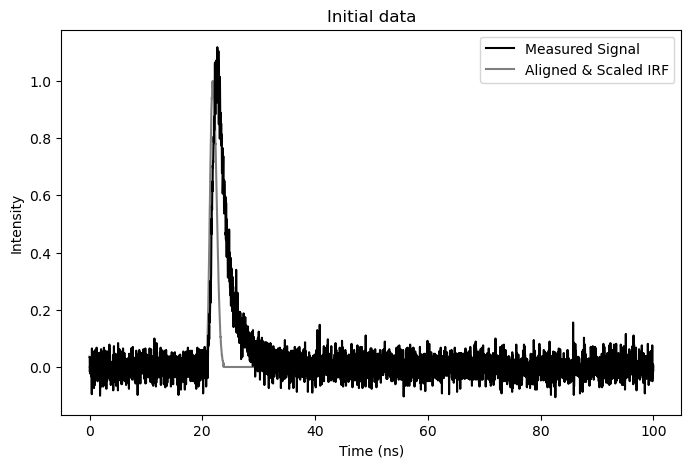

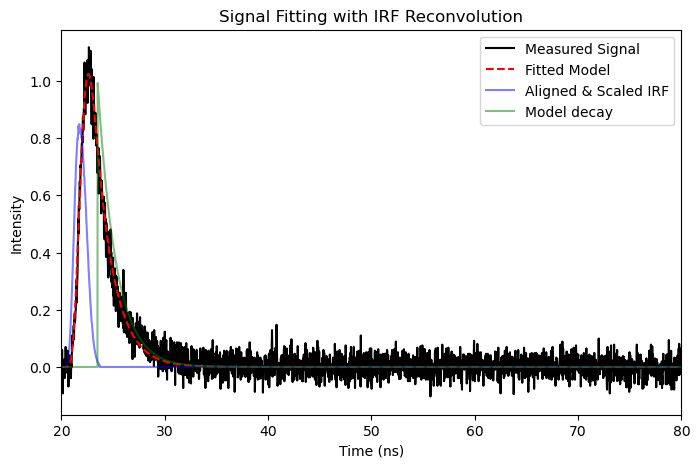

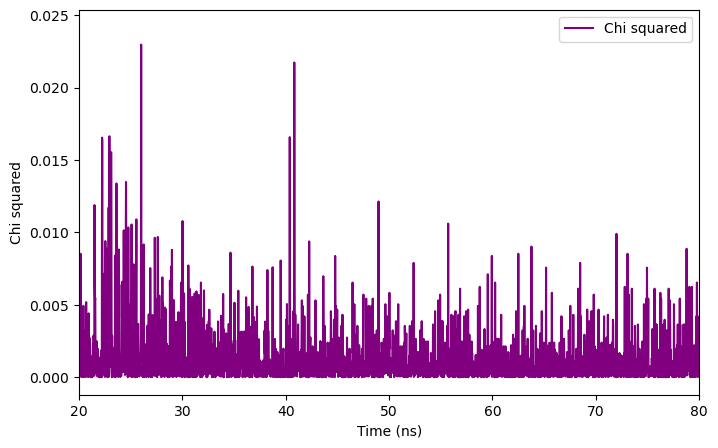

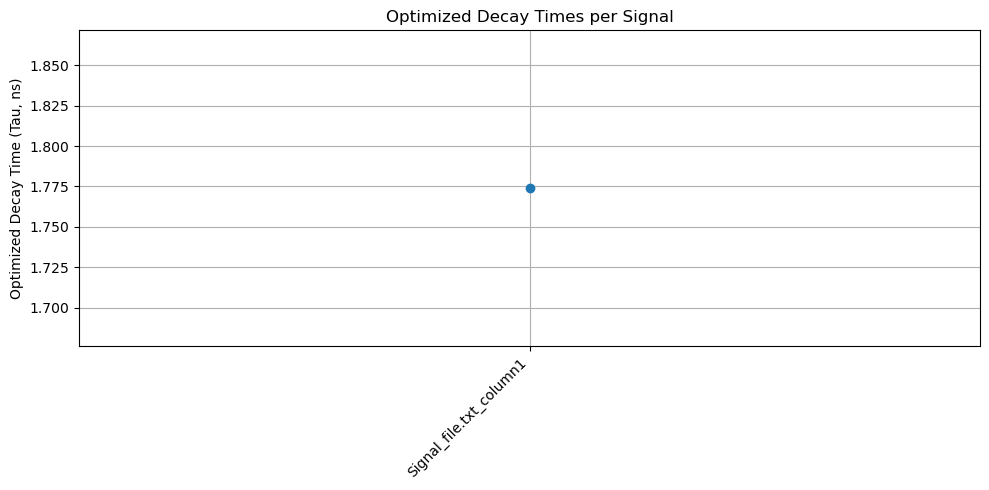

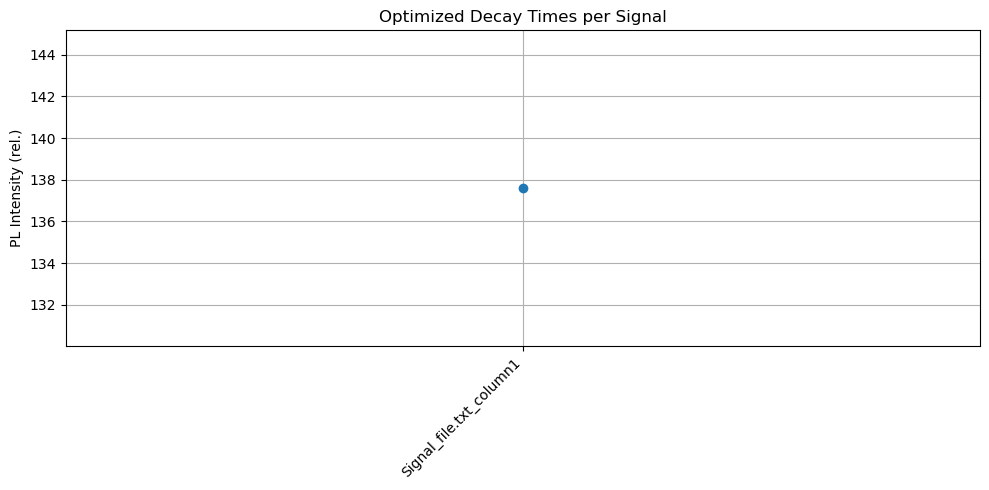

In [22]:

# ==============================
# Process Each Signal Column
# ==============================
columns_to_process = range(1, num_columns + 1) if analyze_all_columns else [signal_column]
lifetime_results = []
intensity_results = []

for col in columns_to_process:
    
    # Initial Peak Alignment
    S_t = data[:, col]  # Select the signal column
    max_index = np.argmax(S_t)
    half_n = n // 2
    start = max(0, max_index - half_n) #stay in bounds
    end = min(len(S_t), max_index + half_n + 1) #stay in bounds
    
    peak_signal = np.mean(time_signal[start:end])
    irf_offset_initial = peak_signal # Align IRF with signal
    model_offset_initial = peak_signal #Align model with signal

    if Invert_data:
        S_t *= -1

    signal_intensity = sum(S_t) #find total intensity before normalizing
    
    S_t /= np.mean(S_t[start:end])  # Normalize signal

    
    #Optimization
    initial_guess = [decay_time_initial, irf_offset_initial, amplitude_scalar_initial, model_offset_initial, model_amplitude_scalar_initial]
    optimized_params = minimize(objective_function, initial_guess, method='Nelder-Mead', bounds=bounds1)

    # Extract optimized values
    optimized_decay_time = optimized_params.x[0]
    optimized_irf_offset = optimized_params.x[1]
    optimized_amplitude_scalar = optimized_params.x[2]
    #optimized_amplitude_scalar =1
    optimized_model_offset = optimized_params.x[3]
    optimized_model_amplitude_scalar = optimized_params.x[4]
    chi_squared_final = objective_function(optimized_params.x)

    # Apply optimized parameters to reconstruct signal
    time_irf_shifted = time_irf_zeroed + optimized_irf_offset
    interp_func = interp1d(time_irf_shifted, IRF_t, kind='linear', fill_value="extrapolate")
    IRF_t_resampled = interp_func(time_signal) * optimized_amplitude_scalar
    S_t_reconvolved = convolve_model(optimized_decay_time, optimized_irf_offset, optimized_model_offset, IRF_t_resampled, optimized_model_amplitude_scalar)
    chi_squared_series = ((S_t - S_t_reconvolved) ** 2)
    
    # Compute the final decay function for plotting, with time offset and zero before the offset
    final_decay_function = np.zeros_like(time_signal)
    final_decay_function[time_signal >= optimized_model_offset] = np.exp(-(time_signal[time_signal >= optimized_model_offset] - optimized_model_offset) / optimized_decay_time)
    #final_decay_function /= np.max(final_decay_function)  # Normalize for comparison
    #final_decay_function *= optimized_model_amplitude_scalar

    # Save Output Data with Optimized Tau in Header
    output_filename = os.path.join(signal_dir, f"{signal_file}_column{col}_output.txt")
    with open(output_filename, "w") as f:
        f.write(f"# Optimized Decay Time (Tau): {optimized_decay_time:.6f}\n")  # Tau in header
        f.write("Time\tMeasured_Signal\tFitted_Model\tDecay_Function\tIRF\n")  # Column names
        np.savetxt(f, np.column_stack((time_signal, S_t, S_t_reconvolved, final_decay_function, IRF_t_resampled)), fmt="%.6f")

    signal_intensity = sum(S_t)
    
    print(f"Processed column {col}, saved output to {output_filename}")
    # Print Results
    
    print(f"Signal intensity: {signal_intensity:.4f}")
    print(f"Optimized Decay Time: {optimized_decay_time:.4f}")
    print(f"Optimized IRF Time Offset: {optimized_irf_offset:.4f}")
    print(f"Optimized Amplitude Scalar: {optimized_amplitude_scalar:.4f}")
    print(f"Optimized Model Offset: {optimized_model_offset:.4f}")
    print(f"Optimized Model Amplitude Scalar: {optimized_model_amplitude_scalar:.4f}")
    print(f"Final χ²: {chi_squared_final:.4f}")
    
    lifetime_results.append((f"{signal_file}_column{col}", optimized_decay_time))
    intensity_results.append((f"{signal_file}_column{col}", signal_intensity))
    
    # Plot Results for the Specified Column
    #if col == signal_column:
    if True:
        plt.figure(figsize=(8, 5))
        plt.plot(time_signal, S_t, label="Measured Signal", color='black')
        plt.plot(time_irf, IRF_t, label="Aligned & Scaled IRF", color="k", alpha=0.5)
        plt.xlabel("Time (ns)")
        plt.ylabel("Intensity")
        plt.legend()
        plt.title("Initial data")
        plt.show()
        
        plt.figure(figsize=(8, 5))
        plt.plot(time_signal, S_t, label="Measured Signal", color='black')
        plt.plot(time_signal, S_t_reconvolved, label="Fitted Model", linestyle='dashed', color='red')
        plt.plot(time_signal, IRF_t_resampled, label="Aligned & Scaled IRF", color="blue", alpha=0.5)
        plt.plot(time_signal, final_decay_function, label="Model decay", color="green", alpha=0.5)
        plt.xlabel("Time (ns)")
        plt.xlim(20, 80)
        plt.ylabel("Intensity")
        plt.legend()
        plt.title("Signal Fitting with IRF Reconvolution")
        plt.show()
        
        
        plt.figure(figsize=(8, 5))
        plt.plot(time_signal, chi_squared_series, label="Chi squared", color='purple')
        plt.xlabel("Time (ns)")
        plt.xlim(20, 80)
        plt.ylabel("Chi squared")
        plt.legend()
        plt.title("")
        plt.show()

# Save lifetimes_output.txt
lifetimes_output_file = os.path.join(signal_dir, "lifetimes_output.txt")
with open(lifetimes_output_file, "w") as f:
    f.write("File\tOptimized_Decay_Time\n")
    for name, tau in lifetime_results:
        f.write(f"{name}\t{tau:.6f}\n")

# Plot decay times
file_labels = [name for name, _ in lifetime_results]
decay_times = [tau for _, tau in lifetime_results]

# Save intensities_output.txt
intensities_output_file = os.path.join(signal_dir, "intensities_output.txt")
with open(intensities_output_file, "w") as f:
    f.write("File\tPL_Intensity\n")
    for name, PL in intensity_results:
        f.write(f"{name}\t{PL:.6f}\n")

# Plot PL intensities
file_labels = [name for name, _ in intensity_results]
PL_intensities = [PL for _, PL in intensity_results]

plt.figure(figsize=(10, 5))
plt.plot(range(len(decay_times)), decay_times, marker='o', linestyle='-')
plt.xticks(range(len(file_labels)), file_labels, rotation=45, ha='right')
plt.ylabel("Optimized Decay Time (Tau, ns)")
plt.title("Optimized Decay Times per Signal")
plt.tight_layout()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(len(PL_intensities)), PL_intensities, marker='o', linestyle='-')
plt.xticks(range(len(file_labels)), file_labels, rotation=45, ha='right')
plt.ylabel("PL Intensity (rel.)")
plt.title("Optimized Decay Times per Signal")
plt.tight_layout()
plt.grid(True)
plt.show()